In [ ]:
pip install GPy

In [ ]:
pip install emukit

In [ ]:
pip install pyDOE

In [ ]:
import GPy
import numpy as np
from pyDOE import lhs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd


ALL_xdata=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/scaled_L2_7_dns_70_e100.csv', header=None)
# Full length
# DNS_ydata=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/scaled_wss_dns11data.csv', header=None)

DNS_ydata=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/scaled_wss_dns11_L2t7data.csv', header=None)
RANS_ydata=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/scaled_wss_LCrans_all_L2t7data.csv',header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Generate sample data

x_train_l =  np.array([[70,100],[70,80],[70,50],[70,30],[70,0],[60,100],[60,80],[60,50],[60,30],[60,0],[50,100],[50,80],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,30],[40,0]])
x_train_h = np.array([[70,100],[70,0],[60,80],[50,50],[40,100],[40,0]])

DNS_full=DNS_ydata.dropna(axis=1)
DNS_full=DNS_full.values
DNS=DNS_full[:,[0,2,3,7,8,10]]


DNS_test=DNS_full[:,[1,4,5,6,9]]
DNS_test=np.transpose(DNS_test)
RANS=RANS_ydata.dropna(axis=1)
RANS_full=RANS.values
RANS_test=RANS_full[:,[0,1,3,4,5,6,7,10,12,13,14,15,16,17,19]]

y_train_h=np.transpose(DNS)
y_train_l=np.transpose(RANS)


print(np.shape(y_train_h))
print(np.shape(y_train_l))
xdatap=ALL_xdata.values
xdata=xdatap[:,[0,1]]
print(xdata.shape)
print(len(xdata))
print(DNS_test.shape)

(6, 10000)
(20, 10000)
(10000, 2)
10000
(5, 10000)


In [ ]:
# from scipy.stats import qmc
# np.random.seed(123)



# # Set the dimension and number of points
# dimension = 1
# num_points =1024
# # Generate Sobol sequence
# sobol_seq = qmc.Sobol(d=dimension, scramble=True).random(num_points)

# # Access the points in the sequence
# points = sobol_seq.T



# # Select indices based on the design points
# selected_indices = np.floor(points * len(xdata)).astype(int)

# Select points from xdata using the selected indices
np.random.seed(123)
num_points =2000# Number of points to select

# Generate Latin Hypercube Design
design = lhs(1, samples=num_points, criterion='maximin')

# Select indices based on the design points
selected_indices = np.floor(design * len(xdata)).astype(int)



In [ ]:
# Select corresponding values from ydata
y_train_h =y_train_h[:,selected_indices.flatten()]



In [ ]:
y_train_l=y_train_l[selected_indices.flatten()]


In [ ]:
print(selected_indices)
print(y_train_h.shape)
print(y_train_l.shape)

[[6775]
 [3065]
 [1520]
 ...
 [7961]
 [7652]
 [7593]]
(6, 2000)
(20, 2000)


In [ ]:
# x_train_l=np.c_[ x_train_l, np.zeros(len(x_train_l)) ]
# x_train_h=np.c_[ x_train_h, np.ones(len(x_train_h)) ]
# X_train=np.append(x_train_l,x_train_h,axis=0)
#
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

# Y_train=np.append(y_train_h,y_train_l,axis=0)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])
print(X_train.shape)
print(Y_train.shape)

print(X_train)

(26, 3)
(26, 2000)
[[ 70. 100.   0.]
 [ 70.  80.   0.]
 [ 70.  50.   0.]
 [ 70.  30.   0.]
 [ 70.   0.   0.]
 [ 60. 100.   0.]
 [ 60.  80.   0.]
 [ 60.  50.   0.]
 [ 60.  30.   0.]
 [ 60.   0.   0.]
 [ 50. 100.   0.]
 [ 50.  80.   0.]
 [ 50.  50.   0.]
 [ 50.  30.   0.]
 [ 50.   0.   0.]
 [ 40. 100.   0.]
 [ 40.  80.   0.]
 [ 40.  50.   0.]
 [ 40.  30.   0.]
 [ 40.   0.   0.]
 [ 70. 100.   1.]
 [ 70.   0.   1.]
 [ 60.  80.   1.]
 [ 50.  50.   1.]
 [ 40. 100.   1.]
 [ 40.   0.   1.]]


In [ ]:
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

In [215]:
## Create standard GP model using only high-fidelity data
x_train_DNS=x_train_h
y_train_DNS=y_train_h
kernelDNS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,5.0],variance=0.0001, ARD=True)
kernelDNS.lengthscale.constrain_bounded(0,10000)
kernelDNS.variance.constrain_bounded(0,10)
high_gp_model = GPy.models.GPRegression(x_train_DNS, y_train_DNS, kernelDNS)
high_gp_model.Gaussian_noise.fix(0.0001)

## Fit the GP model

high_gp_model.optimize_restarts(100)

Optimization restart 1/100, f = -29666.87534520019
Optimization restart 2/100, f = -28166.541053682195
Optimization restart 3/100, f = -28166.545415969696
Optimization restart 4/100, f = -29666.875345205357
Optimization restart 5/100, f = -29666.875345202927
Optimization restart 6/100, f = -28166.561890489444
Optimization restart 7/100, f = -29666.87534520141
Optimization restart 8/100, f = -28166.54084870249
Optimization restart 9/100, f = -29659.47847869174
Optimization restart 10/100, f = -28166.568104674025
Optimization restart 11/100, f = -29654.694979722284
Optimization restart 12/100, f = -29666.875342549858
Optimization restart 13/100, f = -29666.875345205313
Optimization restart 14/100, f = -28166.557226774406
Optimization restart 15/100, f = -29666.875345205215
Optimization restart 16/100, f = -28166.665173728725
Optimization restart 17/100, f = -28166.54037726389
Optimization restart 18/100, f = -29666.875345111817
Optimization restart 19/100, f = -28166.597186530074
Optimiz

 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 78/100, f = -29647.97783375088
Optimization restart 79/100, f = -28166.577867548585
Optimization restart 80/100, f = -29637.970694859945
Optimization restart 81/100, f = -28166.67455842637
Optimization restart 82/100, f = -29666.875345201268
Optimization restart 83/100, f = -28166.556553274833
Optimization restart 84/100, f = -29666.87534519589
Optimization restart 85/100, f = -28166.572385537696
Optimization restart 86/100, f = -28166.542235117176
Optimization restart 87/100, f = -28166.540509035774
Optimization restart 88/100, f = -28166.553233395178
Optimization restart 89/100, f = -28166.5627458815
Optimization restart 90/100, f = -28166.559462330195
Optimization restart 91/100, f = -28166.64482191406
Optimization restart 92/100, f = -28166.541882315178
Optimization restart 93/100, f = -29666.875345205335
Optimization restart 94/100, f = -28166.540373531472
Optimization restart 95/100, f = -29666.87534520308
Optimization restart 96/100, f = -28166.54036952753
O

In [216]:
print(high_gp_model.ExpQuad.lengthscale[0])
print(high_gp_model.ExpQuad.lengthscale[1])
print(high_gp_model.ExpQuad.variance)
print(high_gp_model.gradient)
# Get the gradients of optimization
gradients_dns = high_gp_model.gradient

# Get the names of the model's parameters
parameter_dns = high_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_dns)):
    print(f"Parameter: {parameter_dns[i]} - Gradient: {gradients_dns[i]}")

38.475826075813444
279.30394111385345
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      0.00235170  |   0.0,10.0    |        
[ 4.51698787e-03 -2.63995440e-07 -5.44943480e-08 -7.75158635e+06]
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: 0.004516987868323003
Parameter: ExpQuad.lengthscale - Gradient: -2.639954397400871e-07
Parameter: Gaussian_noise.variance - Gradient: -5.449434803560479e-08


In [217]:
## Create standard GP model using only low-fidelity data

x_train_RANS= np.array([[70,100],[70,80],[70,30],[70,0],[60,100],[60,80],[60,50],[50,100],[50,50],[50,30],[50,0],[40,100],[40,80],[40,50],[40,0]])

y_train_RANS=np.transpose(RANS_test)
print(y_train_RANS.shape)
y_train_RANS=y_train_RANS[:,selected_indices.flatten()]
print(y_train_RANS.shape)


(15, 10000)
(15, 2000)


In [218]:
kernelRANS = GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.05, ARD=True)
kernelRANS.lengthscale.constrain_bounded(0,1000)
kernelRANS.variance.constrain_bounded(0,10)
low_gp_model = GPy.models.GPRegression(x_train_RANS, y_train_RANS, kernelRANS)
low_gp_model.Gaussian_noise.fix(0.001)

## Fit the GP model

low_gp_model.optimize_restarts(500)

Optimization restart 1/500, f = -65937.85221943767
Optimization restart 2/500, f = -65568.20201809503
Optimization restart 3/500, f = -65937.84286284454
Optimization restart 4/500, f = -65937.80250153998
Optimization restart 5/500, f = -65937.84718369273
Optimization restart 6/500, f = -65937.85214812517
Optimization restart 7/500, f = -65937.78153852181
Optimization restart 8/500, f = -65937.83051586778
Optimization restart 9/500, f = -65898.55822454262
Optimization restart 10/500, f = -65568.20942306519
Optimization restart 11/500, f = -65937.85058436237
Optimization restart 12/500, f = -65881.25039446847
Optimization restart 13/500, f = -65568.18800978884
Optimization restart 14/500, f = -65568.4335528819
Optimization restart 15/500, f = -65568.22665764397
Optimization restart 16/500, f = -65937.81826691992
Optimization restart 17/500, f = -65568.20201812909
Optimization restart 18/500, f = -65937.76795215392
Optimization restart 19/500, f = -65937.8047907159
Optimization restart 20

In [219]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[50,50]])
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)


In [220]:
print(low_gp_model.ExpQuad.lengthscale[0])
print(low_gp_model.ExpQuad.lengthscale[1])
print(low_gp_model.ExpQuad.variance)

# Get the gradients of optimization
gradients_rans = low_gp_model.gradient

# Get the names of the model's parameters
parameter_rans = low_gp_model.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_rans)):
    print(f"Parameter: {parameter_rans[i]} - Gradient: {gradients_rans[i]}")

40.56022332754747
1000.0
  index  |  GP_regression.ExpQuad.variance  |  constraints  |  priors
  [0]    |                      0.00088859  |   0.0,10.0    |        
Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: 0.054822274604024376
Parameter: ExpQuad.lengthscale - Gradient: 1.6197301682001915e-06
Parameter: Gaussian_noise.variance - Gradient: 0.003954624629990669


In [221]:
kernels = [GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True),GPy.kern.ExpQuad(input_dim=2,lengthscale=[10,10],variance=0.005, ARD=True)]
# for kernel in kernels:
#     kernel.lengthscale.constrain_bounded(0, 50)
#     kernel.variance.constrain_bounded(0, 10)
for i, kernel in enumerate(kernels):
    if i == 0:  # First fidelity
        kernel.lengthscale.constrain_bounded(0,1000)
        kernel.variance.constrain_bounded(0, 5)
    elif i == 1:  # Second fidelity
        kernel.lengthscale.constrain_bounded(0, 1000)
        kernel.variance.constrain_bounded(0, 10)
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)

gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)

gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0.1)
# gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0.01)

lin_mf_model =model=GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=200)

## Fit the model

lin_mf_model.optimize()

Optimization restart 1/200, f = -39587.601883986514
Optimization restart 2/200, f = -39879.38707349004
Optimization restart 3/200, f = -39774.656112868055
Optimization restart 4/200, f = -39753.01461555856
Optimization restart 5/200, f = -39587.817525267375
Optimization restart 6/200, f = -39859.99895343394
Optimization restart 7/200, f = -38696.38899202343
Optimization restart 8/200, f = -39859.702833797404
Optimization restart 9/200, f = -39860.08411311772
Optimization restart 10/200, f = -39859.82626555217
Optimization restart 11/200, f = -39860.12949696584
Optimization restart 12/200, f = -37945.34439204034
Optimization restart 13/200, f = -39860.06856468638
Optimization restart 14/200, f = -39879.38699947382
Optimization restart 15/200, f = -39587.63230541034
Optimization restart 16/200, f = -39587.631749396285
Optimization restart 17/200, f = -39860.05064249593
Optimization restart 18/200, f = -39879.3870142091
Optimization restart 19/200, f = -39822.08572112088
Optimization rest

In [222]:
 print(gpy_lin_mf_model)


Name : gp
Objective : -39890.51109196434
Number of Parameters : 9
Number of Optimization Parameters : 8
Updates : True
Parameters:
  gp.                                    |                  value  |  constraints  |  priors
  multifidelity.ExpQuad.variance         |  0.0009669541516199832  |    0.0,5.0    |        
  multifidelity.ExpQuad.lengthscale      |                   (2,)  |  0.0,1000.0   |        
  multifidelity.ExpQuad_1.variance       |  0.0005852470568668063  |   0.0,10.0    |        
  multifidelity.ExpQuad_1.lengthscale    |                   (2,)  |  0.0,1000.0   |        
  multifidelity.scale                    |      1.632191049200046  |               |        
  mixed_noise.Gaussian_noise.variance    |                    0.1  |   +ve fixed   |        
  mixed_noise.Gaussian_noise_1.variance  |  8.920674957036064e-06  |      +ve      |        


In [223]:
  print(gpy_lin_mf_model.multifidelity.ExpQuad.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.variance)
  print(gpy_lin_mf_model.multifidelity.ExpQuad.lengthscale)
  print(gpy_lin_mf_model.multifidelity.ExpQuad_1.lengthscale)

  index  |  gp.multifidelity.ExpQuad.variance  |  constraints  |  priors
  [0]    |                         0.00096695  |    0.0,5.0    |        
  index  |  gp.multifidelity.ExpQuad_1.variance  |  constraints  |  priors
  [0]    |                           0.00058525  |   0.0,10.0    |        
  index  |  gp.multifidelity.ExpQuad.lengthscale  |  constraints  |  priors
  [0]    |                           48.88196677  |  0.0,1000.0   |        
  [1]    |                          356.55055614  |  0.0,1000.0   |        
  index  |  gp.multifidelity.ExpQuad_1.lengthscale  |  constraints  |  priors
  [0]    |                             21.12974721  |  0.0,1000.0   |        
  [1]    |                            130.12511154  |  0.0,1000.0   |        


In [224]:
# Get the gradients of optimization
gradients_mf = gpy_lin_mf_model.multifidelity.gradient

# Get the names of the model's parameters
parameter_mf = gpy_lin_mf_model.multifidelity.parameter_names()

# Print the gradients along with the parameter names
print("Gradients of Optimization:")
for i in range(len(parameter_mf)):
    print(f"Parameter: {parameter_mf[i]} - Gradient: {gradients_mf[i]}")

Gradients of Optimization:
Parameter: ExpQuad.variance - Gradient: -33.36276292540806
Parameter: ExpQuad.lengthscale - Gradient: 0.0016660464879427789
Parameter: ExpQuad_1.variance - Gradient: -2.5136558500738937e-05
Parameter: ExpQuad_1.lengthscale - Gradient: -180.6971767404842
Parameter: scale - Gradient: 0.0152461849912146


In [225]:

#x_plot=np.reshape(x,[10000,2])
x_plot=np.array([[70,50],[60,30],[60,0],[50,80],[40,30]])
X_plot_l=np.c_[ x_plot, np.zeros(len(x_plot)) ]
X_plot_h=np.c_[ x_plot, np.ones(len(x_plot)) ]

In [226]:
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)

hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(X_plot_h)
lf_mean_low_gp_model, lf_var_low_gp_model  = low_gp_model.predict(X_plot_h)

In [227]:
xdatap=ALL_xdata.values
xcp=xdatap[:,[0,1]]
xtdata=xcp[selected_indices.flatten()]
ind_pr=3

In [228]:
predarray=hf_mean_lin_mf_model[ind_pr,:].reshape(-1, 1)



In [229]:
ytruth=DNS_test[ind_pr,:].reshape(-1, 1)
# print(ytruth)

In [230]:


# Create a Gaussian Process Regression model
kernel1 = GPy.kern.ExpQuad(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel2 = GPy.kern.Matern32(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel3= GPy.kern.Matern52(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel=kernel1
# kernel = kernel1*kernel2+kernel2*kernel3+kernel3*kernel1
# kernel = kernel1+kernel1*kernel2*kernel3+kernel2+kernel3+kernel1*kernel2+kernel2*kernel3+kernel1*kernel3
# kernel.lengthscale.constrain_bounded(lower=[0, 0], upper=[10, 10])
# kernel.variance.constrain_bounded(lower=0, upper=1)
gpr_model = GPy.models.GPRegression(xtdata,predarray, kernel)

# gpr_model.Gaussian_noise.fix(0.01)
# Optimize the model parameters  gpr_model.optimize()
gpr_model.optimize_restarts(5)



Optimization restart 1/5, f = -11549.786219094518
Optimization restart 2/5, f = -6447.199142218125
Optimization restart 3/5, f = -11549.78621915123
Optimization restart 4/5, f = -11549.786219093336
Optimization restart 5/5, f = -11549.786219071279


In [231]:
# Predict the entire surface
grid_resolution =200  # Resolution of the grid for predictions
x1 = np.linspace(0,1, grid_resolution)
x2 = np.linspace(0,1, grid_resolution)
X_pred = np.meshgrid(x1, x2)
X_pred = np.vstack((X_pred[0].flatten(), X_pred[1].flatten())).T
Y_pred, _ = gpr_model.predict(X_pred)

# Reshape the predictions into a grid
Y_pred_grid = np.reshape(Y_pred, (grid_resolution, grid_resolution))


In [232]:
# Predict the entire surface
grid_resolution =100  # Resolution of the grid for predictions
x1 = np.linspace(0,1, grid_resolution)
x2 = np.linspace(0,1, grid_resolution)
X_pred = np.meshgrid(x1, x2)
X_pred = np.vstack((X_pred[0].flatten(), X_pred[1].flatten())).T
Y_pred, _ = gpr_model.predict(X_pred)

# Reshape the predictions into a grid
Y_pred_grid = np.reshape(Y_pred, (grid_resolution, grid_resolution))

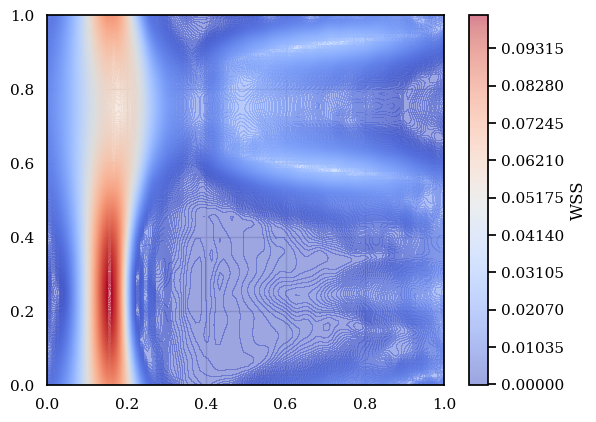

In [233]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as a contour plot
contour = ax.contourf(X_pred[:, 1].reshape(grid_resolution, grid_resolution),
                      X_pred[:, 0].reshape(grid_resolution, grid_resolution),
                      Y_pred_grid, cmap='coolwarm', alpha=0.5, levels=1000)

# ax.set_xlabel('St')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('WSS')

plt.show()


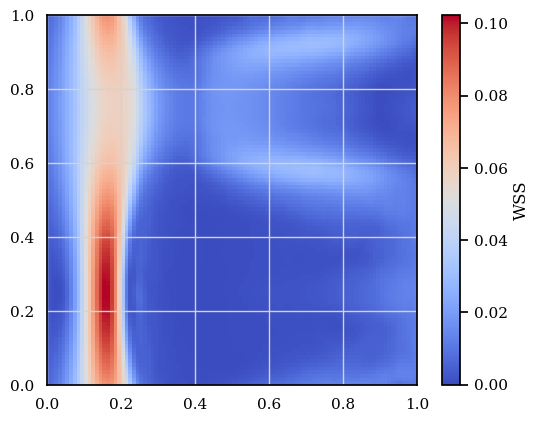

In [234]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as an image
im = ax.imshow(Y_pred_grid.T, cmap='coolwarm', origin='lower', extent=[0,1,0,1])

# Uncomment the following lines if you want to set the x-axis and y-axis labels
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('WSS')

plt.show()

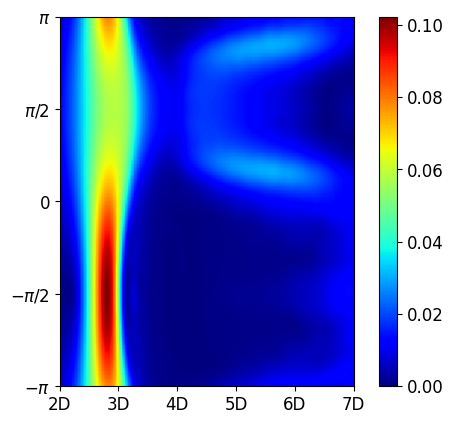

In [235]:
import matplotlib.pyplot as plt
import numpy as np


# Reset matplotlib font settings to default
plt.rcParams.update(plt.rcParamsDefault)

# Set font settings to Times New Roman 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as an image with modified dimensions
im = ax.imshow(Y_pred_grid.T, cmap='jet', origin='lower', extent=[0, 5, -np.pi, np.pi])

# Modify the ticks and labels on the x-axis
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['2D', '3D', '4D', '5D', '6D', '7D'])

# Set the y-axis ticks as regular text
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

# Add a colorbar
cbar = plt.colorbar(im)

# cbar.set_label('WSS')

plt.show()



In [236]:
print((hf_mean_high_gp_model))

dns_pred=hf_mean_high_gp_model[ind_pr,:].reshape(-1, 1)
print(dns_pred.size)


[[0.02261816 0.00309211 0.08764968 ... 0.01574504 0.01709594 0.00332724]
 [0.01267033 0.00242373 0.07685052 ... 0.01167917 0.01280159 0.00257627]
 [0.00746588 0.0023155  0.08494366 ... 0.00804412 0.00820456 0.0026682 ]
 [0.0126423  0.00213319 0.04398603 ... 0.01314879 0.01607834 0.00170733]
 [0.00050438 0.00208266 0.03666125 ... 0.00426815 0.00562346 0.00129512]]
2000


In [237]:


# Create a Gaussian Process Regression model
kernel1 = GPy.kern.ExpQuad(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel2 = GPy.kern.Matern32(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel3= GPy.kern.Matern52(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel=kernel1
# kernel = kernel1*kernel2+kernel2*kernel3+kernel3*kernel1
# kernel = kernel1+kernel1*kernel2*kernel3+kernel2+kernel3+kernel1*kernel2+kernel2*kernel3+kernel1*kernel3
# kernel.lengthscale.constrain_bounded(lower=[0, 0], upper=[10, 10])
# kernel.variance.constrain_bounded(lower=0, upper=1)
dns_gpr_model = GPy.models.GPRegression(xtdata,dns_pred, kernel)


# Optimize the model parameters  gpr_model.optimize()
dns_gpr_model.optimize_restarts(5)

Optimization restart 1/5, f = -11144.601191125827
Optimization restart 2/5, f = -7760.954164727844
Optimization restart 3/5, f = -11217.508586101987
Optimization restart 4/5, f = -8332.964597628346
Optimization restart 5/5, f = -11144.601191116677


In [238]:
# #####################DNS_GPR# Predict the entire surface
grid_resolution =100  # Resolution of the grid for predictions
x1 = np.linspace(0,1, grid_resolution)
x2 = np.linspace(0,1, grid_resolution)
X_pred = np.meshgrid(x1, x2)
X_pred = np.vstack((X_pred[0].flatten(), X_pred[1].flatten())).T
dns_pred, _ = dns_gpr_model.predict(X_pred)

# Reshape the predictions into a grid
dns_pred_grid = np.reshape(dns_pred, (grid_resolution, grid_resolution))

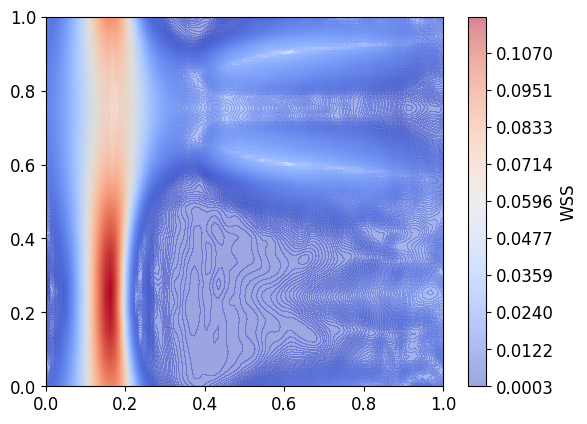

In [239]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as a contour plot
contour = ax.contourf(X_pred[:, 1].reshape(grid_resolution, grid_resolution),
                      X_pred[:, 0].reshape(grid_resolution, grid_resolution),
                      dns_pred_grid, cmap='coolwarm', alpha=0.5, levels=1000)

# ax.set_xlabel('St')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('WSS')

plt.show()


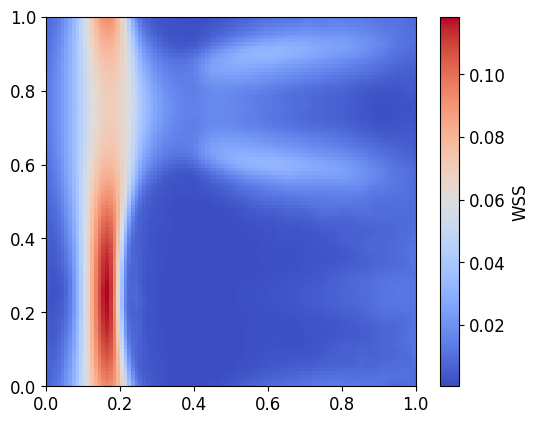

In [240]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as an image
im = ax.imshow(dns_pred_grid.T, cmap='coolwarm', origin='lower', extent=[0,1,0,1])

# Uncomment the following lines if you want to set the x-axis and y-axis labels
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('WSS')

plt.show()

In [241]:
 print(DNS_test[[0],:].shape)

(1, 10000)


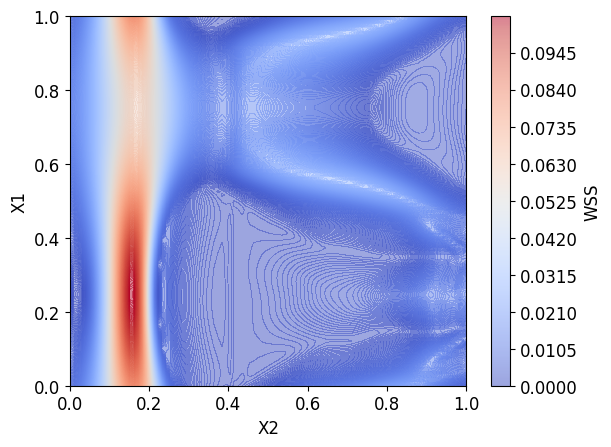

In [242]:

import matplotlib.pyplot as plt

# Reshape the ydata for contour plot
arr_reshaped = DNS_test[[ind_pr],:].reshape((100, 100))
# Predict the entire surface
gres =100  # Resolution of the grid for predictions
xr1 = np.linspace(0,1, gres)
xr2 = np.linspace(0,1, gres)
X_r = np.meshgrid(xr1, xr2)
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the surface as a contour plot
contour = ax.contourf(X_r[0], X_r[1],arr_reshaped, cmap='coolwarm', alpha=0.5, levels=1000)

# Set labels for the x-axis and y-axis
ax.set_xlabel('X2')
ax.set_ylabel('X1')

# Add a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('WSS')

# Show the plot
plt.show()





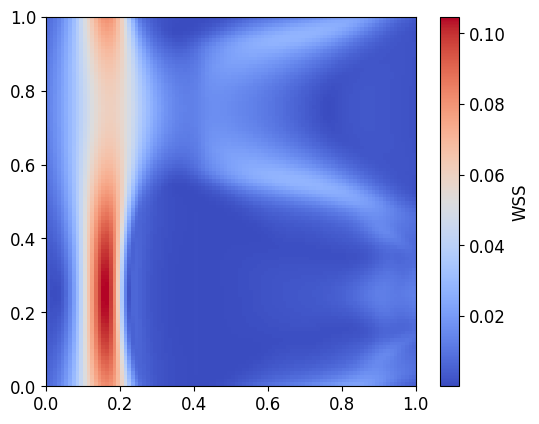

In [243]:

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as an image
im = ax.imshow(arr_reshaped, cmap='coolwarm', origin='lower', extent=[0,1,0,1])

# Uncomment the following lines if you want to set the x-axis and y-axis labels
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(im)
cbar.set_label('WSS')

plt.show()

In [244]:
rans_pred=lf_mean_low_gp_model[ind_pr,:].reshape(-1, 1)
print(rans_pred.size)
print(xtdata.size)

2000
4000


In [245]:

# Create a Gaussian Process Regression model
kernel1 = GPy.kern.ExpQuad(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel2 = GPy.kern.Matern32(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel3= GPy.kern.Matern52(input_dim=2,lengthscale=[0.1,0.1],variance=0.01,ARD=True)
kernel=kernel1
# kernel = kernel1*kernel2+kernel2*kernel3+kernel3*kernel1
# kernel = kernel1+kernel1*kernel2*kernel3+kernel2+kernel3+kernel1*kernel2+kernel2*kernel3+kernel1*kernel3
# kernel.lengthscale.constrain_bounded(lower=[0, 0], upper=[10, 10])
# kernel.variance.constrain_bounded(lower=0, upper=1)
rans_gpr_model = GPy.models.GPRegression(xtdata,rans_pred, kernel)


# Optimize the model parameters  gpr_model.optimize()
rans_gpr_model.optimize_restarts(5)


Optimization restart 1/5, f = -10474.942700417694


 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:657: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -8200.813947993302
Optimization restart 3/5, f = -10474.942700403222
Optimization restart 4/5, f = -7195.324783466528
Optimization restart 5/5, f = -10474.9427004065


In [246]:
# #####################DNS_GPR# Predict the entire surface
grid_resolution =100  # Resolution of the grid for predictions
x1 = np.linspace(0,1, grid_resolution)
x2 = np.linspace(0,1, grid_resolution)
X_pred = np.meshgrid(x1, x2)
X_pred = np.vstack((X_pred[0].flatten(), X_pred[1].flatten())).T
rans_pred, _ = rans_gpr_model.predict(X_pred)

# Reshape the predictions into a grid
rans_pred_grid = np.reshape(rans_pred, (grid_resolution, grid_resolution))

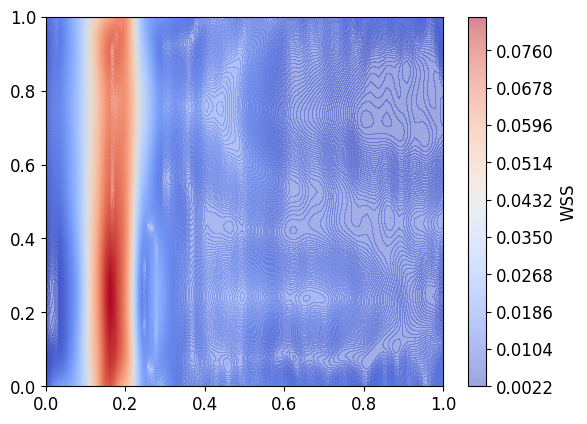

In [247]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the surface as a contour plot
contour = ax.contourf(X_pred[:, 1].reshape(grid_resolution, grid_resolution),
                      X_pred[:, 0].reshape(grid_resolution, grid_resolution),
                      rans_pred_grid, cmap='coolwarm', alpha=0.5, levels=1000)

# ax.set_xlabel('St')
# ax.set_ylabel('X2')

# Add a colorbar
cbar = plt.colorbar(contour)
cbar.set_label('WSS')

plt.show()

In [248]:
# import numpy as np
# # Y values from -π to π

values = ["70_50", "60_30", "60_0", "50_80", "40_30"]  # Replace with your desired values
value="60_30"
# # Save X and Y to CSV files
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/X_data.csv', X, delimiter=',')
# np.savetxt('/content/drive/MyDrive/ColabNotebooks/Y_data.csv', Y, delimiter=',')
np.savetxt('/content/drive/MyDrive/ColabNotebooks/MFsurfE50_80.csv', Y_pred_grid, delimiter=',')
np.savetxt('/content/drive/MyDrive/ColabNotebooks/RANSGPsurfE50_80.csv', rans_pred_grid, delimiter=',')
np.savetxt('/content/drive/MyDrive/ColabNotebooks/DNSGPsurfE50_80.csv', dns_pred_grid, delimiter=',')
np.savetxt('/content/drive/MyDrive/ColabNotebooks/TruthsurfE50_80.csv', arr_reshaped, delimiter=',')

In [249]:
plt.figure(figsize=(12, 12))
plt.scatter(Y_pred_grid.T, arr_reshaped, c='red')
min_max = [arr_reshaped.min(),arr_reshaped.max()]
plt.plot(min_max, min_max, color='black',linestyle='dotted')

# plt.fill_between(x,curv1,curv2, color='green',
#                  alpha=0.5)


plt.xlabel('Truth')
plt.ylabel('Prediction');

 /usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1826: UserWarning:

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

 /usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1826: FutureWarning:

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



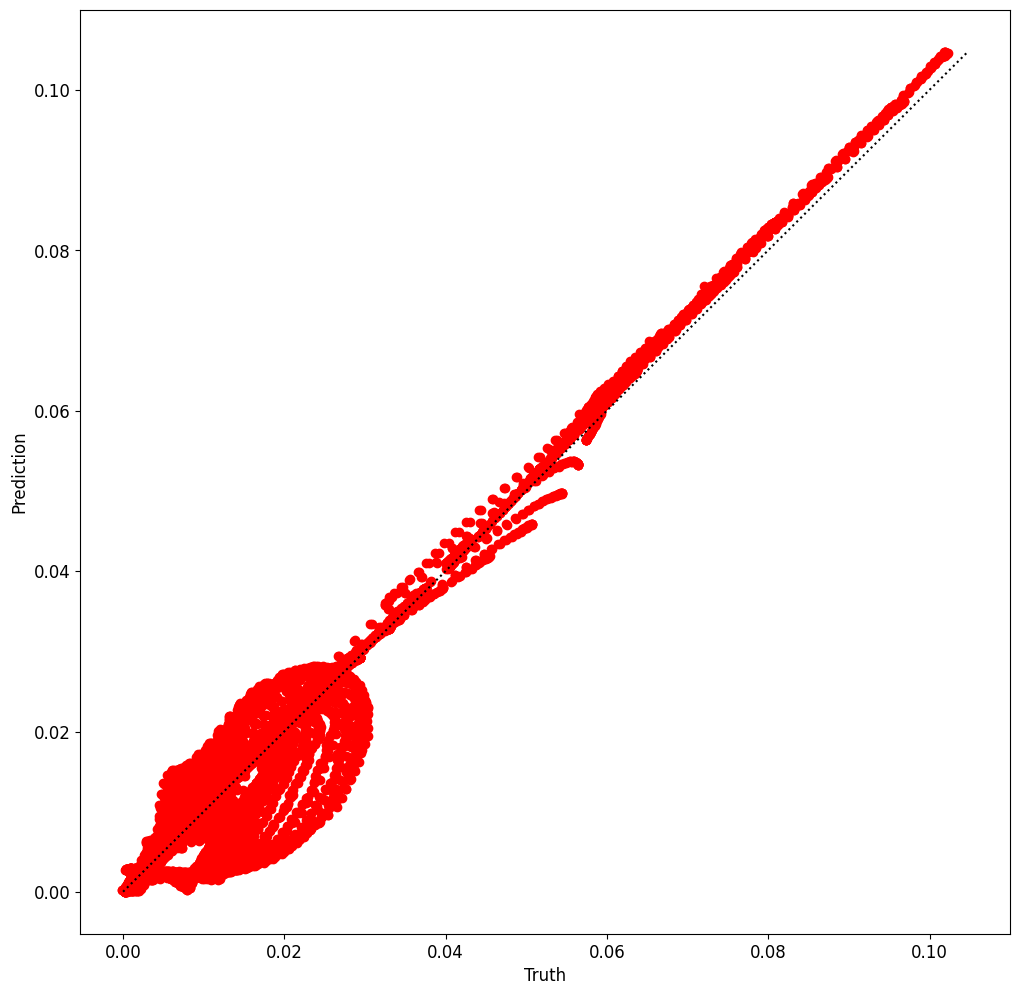

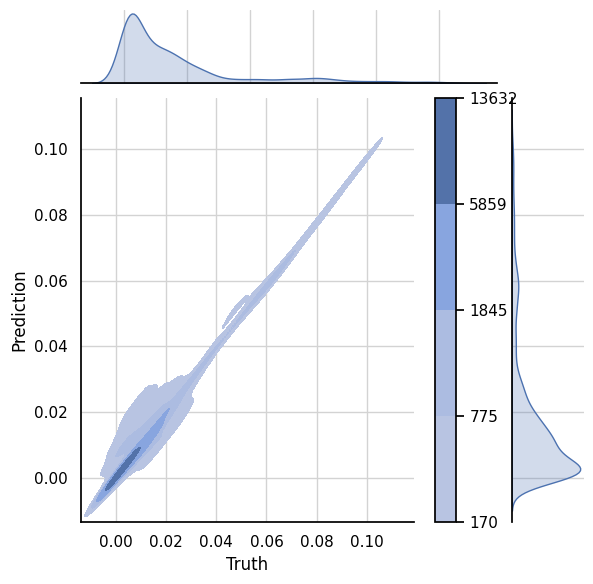

In [250]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'Truth': arr_reshaped.flatten(),'Prediction':Y_pred_grid.T.flatten()})
sns.set(font={'family':'serif', 'size':12}, rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.edgecolor':'black', 'axes.labelcolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'grid.color':'lightgray'})

rel=sns.jointplot( x="Truth",y="Prediction", kind = "kde",data = df, fill=True, n_levels = 5, shade = True, cbar = True, shade_lowest = False, cbar_kws={"location":   "right"})
#rel.fig.suptitle("k=0.96")


plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


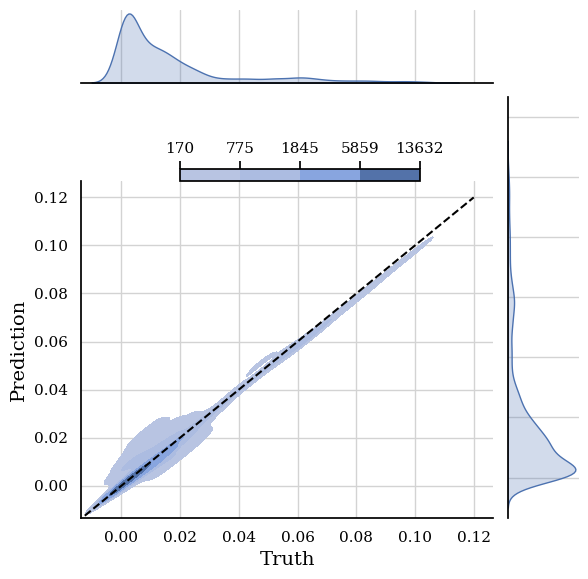

In [251]:
# Set seaborn and matplotlib font settings
sns.set(font_scale=1.0, style="whitegrid", rc={
    'font.family': 'serif',
    'font.size': 14,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'grid.color': 'lightgray'
})

# Create the jointplot with custom contour levels
rel = sns.jointplot(x="Truth", y="Prediction", kind="kde", data=df, fill=True, n_levels=5, thresh=0.05, cbar=True, cbar_kws={"location": "top"})
rel.set_axis_labels("Truth", "Prediction", fontsize=14)

# Calculate the minimum and maximum values for the 45-degree line
min_val = min(-0.0125,-0.0125)
max_val = max(0.12, 0.12)
x = [min_val, max_val]
y = [min_val, max_val]

# Plot the 45-degree line
rel.ax_joint.plot(x, y, linestyle='dashed', color='black')

# Adjust the size and position of the colorbar
cbar_ax = rel.fig.axes[-1]
cbar_ax.set_position([.25, .68, .5, .02])  # [left, bottom, width, height]



from google.colab import drive
drive.mount('/content/drive')

plt.savefig('/content/drive/MyDrive/ColabNotebooks/PDFsurf_E50_80.pdf', bbox_inches='tight')

# Show the plot
plt.show()